In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%autoreload # When utils.py is updated
#from utils_unet_resunet import *
from ops import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from model.callbacks import UpdateWeights
#from model.models import *
from model.losses import WBCE, WCCE
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import os
import gc
import json
import importlib
#from utils_unet_resunet import build_unet

## Parameters

In [3]:
with open(f'00_params.json') as param_file:
    params = json.load(param_file)

img_path = 'imgs' 
n_opt_layer = 26 #number of OPT layers, used to split de input data between OPT and SAR

number_class = 3
weights = params['weights']
times= params['times']
exp = params['exp']

overlap = params['overlap']
patch_size = params['patch_size']
batch_size = params['batch_size']

img_type = params['img_type']
cond = params['cond']
test_cond = params['test_cond']

nb_filters = params['nb_filters']

method = params['method']
module = importlib.import_module('model.models')
exp_model = getattr(module, method)

grid_size = params['grid_size']

tiles_tr = params['tiles_tr']
tiles_val = params['tiles_val']

## Load file

In [4]:
image_array = np.load(os.path.join(img_path, f'fus_stack_{cond}.npy'))

if img_type == 'OPT':
    image_array = image_array[:, :, :n_opt_layer]
    
if img_type == 'SAR':
    image_array = image_array[:, :, n_opt_layer:]
    
print('Image stack:', image_array.shape)

final_mask1 = np.load(os.path.join(img_path, 'final_mask1.npy'))
print('Labels stack:', final_mask1.shape)
h_, w_, channels = image_array.shape

Image stack: (17730, 9203, 4)
Labels stack: (17730, 9203)


## Create tiles mask

mask:  (17730, 9203)
image stack:  (17730, 9203, 4)
ref : (17730, 9203)


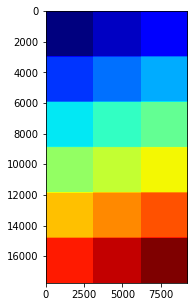

In [5]:
mask_tiles = create_mask(final_mask1.shape[0], final_mask1.shape[1], grid_size=grid_size)
image_array = image_array[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
final_mask1 = final_mask1[:mask_tiles.shape[0], :mask_tiles.shape[1]]

print('mask: ',mask_tiles.shape)
print('image stack: ', image_array.shape)
print('ref :', final_mask1.shape)
plt.figure(figsize=(10,5))
plt.imshow(mask_tiles, cmap='jet')

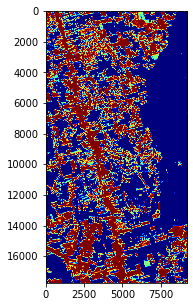

In [6]:
plt.figure(figsize=(10,5))
plt.imshow(final_mask1, cmap = 'jet')

## Define tiles for training, validation and tests.

In [7]:
tiles_ts = (list(set(np.arange(tiles_val[0]*tiles_val[1])+1)-set(tiles_tr)-set(tiles_val)))

mask_tr_val = np.zeros((mask_tiles.shape)).astype('float32')
# Training and validation mask
for tr_ in tiles_tr:
    mask_tr_val[mask_tiles == tr_] = 1

for val_ in tiles_val:
    mask_tr_val[mask_tiles == val_] = 2

#mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
#for ts_ in tiles_ts:
#    mask_amazon_ts[mask_tiles == ts_] = 1

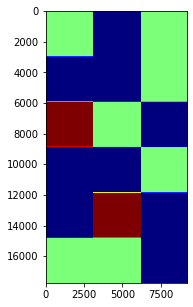

In [8]:
plt.figure(figsize=(10,5))
plt.imshow(mask_tr_val, cmap='jet')

## Create index image to extract patches without overcharge the system.

In [9]:
im_idx = create_idx_image(final_mask1)

patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size) #índice do pixel de cada patch
patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size) #1 se pixel for de treinamento 2 se for val
del im_idx

## Select training, validation and test patches, keeping a minumum of 2% of deforestation pixels, to minimize the imbalance.

In [10]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2)) #extrai apenas idx dos patches com todos os valores == 1 (train)
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2)) #extrai apenas idx dos patches com todos os valores == 2 (val)
del patches_mask

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
del idx_trn, idx_val

print('Number of training patches:  ', len(patches_idx_trn), 'Number of validation patches', len(patches_idx_val))

Number of training patches:   41026 Number of validation patches 11544


In [11]:
# Extract patches with at least 2% of deforestation class
X_train = retrieve_idx_percentage(final_mask1, patches_idx_trn, patch_size, pertentage = 2)
X_valid = retrieve_idx_percentage(final_mask1, patches_idx_val, patch_size, pertentage = 2)
print(X_train.shape, X_valid.shape)
del patches_idx_trn, patches_idx_val
gc.collect()

(2213, 128, 128) (579, 128, 128)


0

In [12]:
train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True)
valid_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = True)

Y_train = np.zeros_like(X_train)
Y_valid = np.zeros_like(X_valid)

train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), Y_train,
                              batch_size=batch_size,
                              shuffle=True)

valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), Y_valid,
                              batch_size=batch_size,
                              shuffle=False)


In [13]:
def batch_generator(batches, image, reference, target_size, number_class):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    image = image.reshape(-1, image.shape[-1])
    reference = reference.reshape(final_mask1.shape[0]*final_mask1.shape[1])
    while True:
        batch_x, _ = next(batches)
        batch_x = np.squeeze(batch_x.astype('int64'))
        #print(batch_x.shape)
        batch_img = np.zeros((batch_x.shape[0], target_size, target_size, image.shape[-1]))
        batch_ref = np.zeros((batch_x.shape[0], target_size, target_size, number_class))
        
        for i in range(batch_x.shape[0]):
            if np.random.rand()>0.5:
                batch_x[i] = np.rot90(batch_x[i], 1)
            batch_img[i] = image[batch_x[i]] 
            batch_ref[i] = to_categorical(reference[batch_x[i]] , number_class)
                       
        yield (batch_img, batch_ref)

In [14]:
train_gen_crops = batch_generator(train_gen, image_array, final_mask1, patch_size, number_class)
valid_gen_crops = batch_generator(valid_gen, image_array, final_mask1, patch_size, number_class)

In [15]:
path_exp = os.path.join(img_path, 'experiments', f'exp_{exp}')
path_models = os.path.join(path_exp, 'models')
path_maps = os.path.join(path_exp, 'pred_maps')

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

In [16]:
# Parameters of the model
input_shape = (patch_size, patch_size, channels)
#adam = Adam(lr = 1e-3 , beta_1=0.9)
#loss = weighted_categorical_crossentropy(weights)
#loss = WBCE(weights = weights)
#loss = WBCE(weights = weights, class_indexes = [0, 1])


In [17]:
metrics_all = []

for tm in range(0,times):
    
    print('time: ', tm)
    rows = patch_size
    cols = patch_size
    adam = Adam(lr = 1e-4 , beta_1=0.9)
    loss = WBCE(weights = weights)
    #loss = WCCE(weights = weights)
    model = exp_model(nb_filters, number_class)
    model.build((None,)+input_shape)
    #model = build_unet(input_shape, nb_filters, number_class)
    model.summary()
    
    # train the model
    start_training = time.time()
    
    #model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
    model.compile(optimizer=adam, loss=loss, metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='min')
    checkpoint = ModelCheckpoint(os.path.join(path_models, f'{method}_{tm}.h5'), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
    callbacks_list = [earlystop, checkpoint]
    history = model.fit(train_gen_crops,
                              steps_per_epoch=3*(len(X_train)//train_gen.batch_size),
                              validation_data=valid_gen_crops,
                              validation_steps=3*(len(X_valid)//valid_gen.batch_size),
                              epochs=100,
                              callbacks=callbacks_list)
    
    end_training = time.time() - start_training
    metrics_all.append(end_training)
    del model, history


time:  0
Model: "unet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unet_encoder (UNET_Encoder)  multiple                  536288    
_________________________________________________________________
unet_decoder (UNET_Decoder)  multiple                  332000    
_________________________________________________________________
classifier (Classifier)      multiple                  195       
Total params: 868,483
Trainable params: 868,483
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
207/207 [==============================] - 16s 46ms/step - loss: 0.1529 - accuracy: 0.7605 - val_loss: 0.0982 - val_accuracy: 0.8322

Epoch 00001: val_loss improved from inf to 0.09821, saving model to imgs\experiments\exp_2\models\UNET_0.h5
Epoch 2/100
207/207 [==============================] - 8s 39ms/step - loss: 0.1089 - accuracy: 0.8300 - val_loss: 0.0953 - 

207/207 [==============================] - 13s 65ms/step - loss: 0.0976 - accuracy: 0.8426 - val_loss: 0.0898 - val_accuracy: 0.8423

Epoch 00004: val_loss improved from 0.09690 to 0.08980, saving model to imgs\experiments\exp_2\models\UNET_2.h5
Epoch 5/100
207/207 [==============================] - 14s 66ms/step - loss: 0.0902 - accuracy: 0.8532 - val_loss: 0.0877 - val_accuracy: 0.8464

Epoch 00005: val_loss improved from 0.08980 to 0.08766, saving model to imgs\experiments\exp_2\models\UNET_2.h5
Epoch 6/100
207/207 [==============================] - 14s 66ms/step - loss: 0.0869 - accuracy: 0.8569 - val_loss: 0.0912 - val_accuracy: 0.8384

Epoch 00006: val_loss did not improve from 0.08766
Epoch 7/100
207/207 [==============================] - 14s 66ms/step - loss: 0.0830 - accuracy: 0.8600 - val_loss: 0.0941 - val_accuracy: 0.8441

Epoch 00007: val_loss did not improve from 0.08766
Epoch 8/100
207/207 [==============================] - 14s 66ms/step - loss: 0.0780 - accuracy: 0.8655